# Import Model Architectures

Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [11]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


# Loading the Model Weights

Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [12]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device('cpu')))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device('cpu')))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [14]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [15]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [16]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

# Carlini and Wagner attack

The Carlini and Wagner attack is a regularization based white box attack takes in a couple inputs: c, that lets you control how much influence the "maximum allowable" portion of the regularization based attack has, alpha, the learning rate of the optimizer used within the attack, and kappa denoted in the literature as "confidence" value. Implemented here is the $L_2$-norm CW attack. The attack itself is described as: given $x$, we choose a target class $t$ such that $t \neq C^\ast(x)$ and then search for $w$ that solves

$$ \text{minimize } \left\lVert \frac{1}{2} \left(\text{tanh}(w) + 1\right) - x \right\rVert^2_2 + c \cdot f\left(\frac{1}{2}(\text{tanh}(w) + 1)\right) $$

with $f$ defined as

$$ f(x') = \text{max}\{ \text{max} \{Z(x')_i : i \neq t \} - Z(x')_t , -\kappa \}. $$

Also, if $F : x \mapsto y$ is the neural network, then $Z$ is all of the layers before the softmax layer at the end. That is,

$$ F(x) = \text{softmax}(Z(x)) .$$

The general conclusion is that untargeted attacks perform better at tanking model performance than targeted attacks, which is common sense. Additionally, some labels are too costly to attempt to target, so model performance will be unaffected if those targets are chosen.

In [26]:
print("Attack Image & Predicted Label")
viz = Visualizer()


def test_cw(model, test_loader, targeted=False, target_label=0, c=0.75, alpha=0.01, kappa= 0, max_iterations=50, mnist = 1):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            

            
            advimages = cw_attack(image, model, init_pred, targeted, target_label, c, alpha, kappa, max_iterations)
            output_adv, _ = model(advimages)
            # advimages = advimages[0,:,:,:] / 255

            #print(advimages.shape)
            #viz.show(advimages.detach())
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
            
                if not targeted: 
                    #if prediction_adv not in pred_list:
                    adv_ex = advimages.squeeze().detach().cpu().numpy()
                    
                    #if not mnist:
                        #adv_ex = adv_ex/255
                    
                    adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                    pred_list.append(prediction_adv)
                else:
                    adv_ex = advimages.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                
                        
            total +=1 
            print(correct, "/", total)  
            
        
    accuracy = (float(correct) / total) * 100       
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return accuracy, adv_examples

Attack Image & Predicted Label


## Hyperparameter tuning

In [27]:
c_vals = [0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
mnist_accuracies = []
svhn_accuracies = []
cifar10_accuracies = []

for c_mnist in c_vals:
    acc, _ = test_cw(mnist_resnet_model, test_loader_mnist, c=c_mnist, mnist = 1)
    mnist_accuracies.append(acc)

0 / 1
0 / 2
1 / 3
1 / 4
1 / 5
2 / 6
2 / 7
2 / 8
2 / 9
2 / 10
2 / 11
2 / 12
2 / 13
2 / 14
3 / 15
3 / 16
3 / 17
3 / 18
3 / 19
3 / 20
3 / 21
3 / 22
3 / 23
3 / 24
3 / 25
3 / 26
3 / 27
3 / 28
3 / 29
4 / 30
4 / 31
5 / 32
5 / 33
5 / 34
5 / 35
5 / 36
5 / 37
6 / 38
6 / 39
7 / 40
8 / 41
8 / 42
8 / 43
8 / 44
8 / 45
8 / 46
9 / 47
9 / 48
9 / 49
9 / 50
9 / 51
9 / 52
9 / 53
9 / 54
9 / 55
9 / 56
9 / 57
9 / 58
9 / 59
9 / 60
9 / 61
9 / 62
9 / 63
9 / 64
9 / 65
9 / 66
9 / 67
9 / 68
9 / 69
9 / 70
9 / 71
9 / 72
9 / 73
9 / 74
10 / 75
10 / 76
10 / 77
10 / 78
10 / 79
10 / 80
10 / 81
10 / 82
10 / 83
10 / 84
10 / 85
10 / 86
10 / 87
10 / 88
10 / 89
10 / 90
10 / 91
10 / 92
10 / 93
10 / 94
11 / 95
11 / 96
12 / 97
12 / 98
12 / 99
12 / 100
12 / 101
12 / 102
12 / 103
12 / 104
12 / 105
12 / 106
12 / 107
13 / 108
13 / 109
13 / 110
13 / 111
13 / 112
13 / 113
13 / 114
13 / 115
13 / 116
13 / 117
13 / 118
13 / 119
13 / 120
13 / 121
13 / 122
13 / 123
13 / 124
13 / 125
13 / 126
13 / 127
13 / 128
13 / 129
13 / 130
13 / 131
13 

10 / 236
10 / 237
10 / 238
10 / 239
11 / 240
11 / 241
11 / 242
11 / 243
11 / 244
11 / 245
11 / 246
11 / 247
11 / 248
11 / 249
11 / 250
11 / 251
11 / 252
11 / 253
11 / 254
11 / 255
11 / 256
Accuracy of test text: 4.296875 %
0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
0 / 56
0 / 57
0 / 58
0 / 59
0 / 60
0 / 61
0 / 62
0 / 63
0 / 64
0 / 65
0 / 66
0 / 67
0 / 68
0 / 69
0 / 70
0 / 71
0 / 72
0 / 73
0 / 74
0 / 75
0 / 76
0 / 77
0 / 78
0 / 79
0 / 80
0 / 81
0 / 82
0 / 83
0 / 84
0 / 85
0 / 86
0 / 87
0 / 88
0 / 89
0 / 90
0 / 91
0 / 92
0 / 93
0 / 94
0 / 95
0 / 96
0 / 97
0 / 98
0 / 99
0 / 100
0 / 101
0 / 102
0 / 103
0 / 104
0 / 105
0 / 106
0 / 107
0 / 108
0 / 109
0 / 110
0 / 1

0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
0 / 56
0 / 57
0 / 58
0 / 59
0 / 60
0 / 61
0 / 62
0 / 63
0 / 64
0 / 65
0 / 66
0 / 67
0 / 68
0 / 69
0 / 70
0 / 71
0 / 72
0 / 73
0 / 74
0 / 75
0 / 76
0 / 77
0 / 78
0 / 79
0 / 80
0 / 81
0 / 82
0 / 83
0 / 84
0 / 85
0 / 86
0 / 87
0 / 88
0 / 89
0 / 90
0 / 91
0 / 92
0 / 93
0 / 94
0 / 95
0 / 96
0 / 97
0 / 98
0 / 99
0 / 100
0 / 101
0 / 102
0 / 103
0 / 104
0 / 105
0 / 106
0 / 107
0 / 108
0 / 109
0 / 110
0 / 111
0 / 112
0 / 113
0 / 114
0 / 115
0 / 116
0 / 117
0 / 118
0 / 119
0 / 120
0 / 121
0 / 122
0 / 123
0 / 124
0 / 125
0 / 126
0 / 127
0 / 128
0 / 129
0 / 130
0 / 131
0 / 132
0 / 133
0 / 134
0 / 135
0 / 136
0 / 137
0 / 138
0 / 139
0 / 140
0 / 141
0 / 142
0 / 143
0 / 144
0 / 145
0 / 146
0 / 147
0 / 148

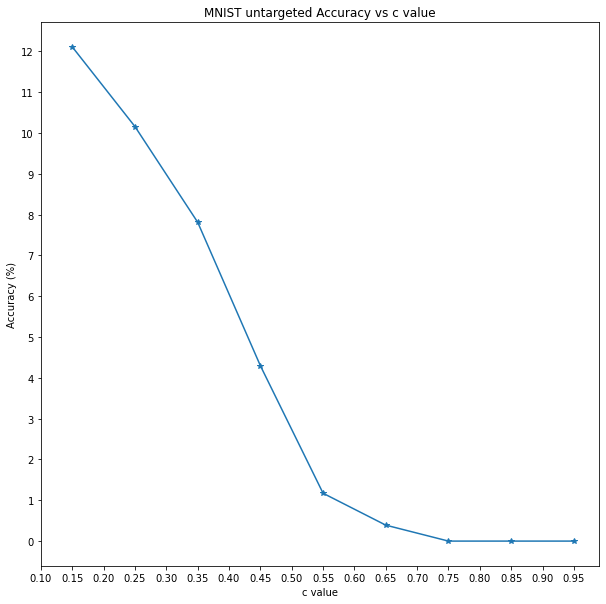

In [83]:
plt.figure(figsize=(10,10))
plt.plot(c_vals, mnist_accuracies, "*-")
plt.yticks(np.arange(0, 13, step=1))
plt.xticks(np.arange(0.1, 1, step=0.05))
plt.title("MNIST untargeted Accuracy vs c value")
plt.xlabel("c value")
plt.ylabel("Accuracy (%)")
plt.show()

In [47]:
for c_svhn in c_vals:
    acc, _ = test_cw(svhn_resnet_model, test_loader_svhn, c=c_svhn, mnist = 0)
    svhn_accuracies.append(acc)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
1 / 31
1 / 32
1 / 33
1 / 34
1 / 35
1 / 36
1 / 37
1 / 38
1 / 39
1 / 40
1 / 41
1 / 42
1 / 43
1 / 44
1 / 45
1 / 46
1 / 47
1 / 48
1 / 49
1 / 50
1 / 51
1 / 52
1 / 53
1 / 54
1 / 55
2 / 56
2 / 57
2 / 58
3 / 59
3 / 60
3 / 61
3 / 62
3 / 63
3 / 64
3 / 65
3 / 66
3 / 67
3 / 68
3 / 69
3 / 70
3 / 71
3 / 72
3 / 73
3 / 74
3 / 75
3 / 76
3 / 77
3 / 78
3 / 79
3 / 80
3 / 81
3 / 82
3 / 83
3 / 84
3 / 85
3 / 86
3 / 87
3 / 88
3 / 89
3 / 90
3 / 91
3 / 92
3 / 93
3 / 94
3 / 95
3 / 96
3 / 97
3 / 98
3 / 99
3 / 100
3 / 101
3 / 102
3 / 103
3 / 104
3 / 105
3 / 106
3 / 107
3 / 108
3 / 109
3 / 110
3 / 111
3 / 112
3 / 113
4 / 114
4 / 115
4 / 116
4 / 117
4 / 118
4 / 119
4 / 120
4 / 121
4 / 122
4 / 123
4 / 124
4 / 125
4 / 126
4 / 127
4 / 128
4 / 129
4 / 130
4 / 131
4 / 132
4 / 133
4 / 134
4 / 135
4 / 136
4 / 137
4 / 138
4 / 

0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
1 / 56
1 / 57
1 / 58
2 / 59
2 / 60
2 / 61
2 / 62
2 / 63
2 / 64
2 / 65
2 / 66
2 / 67
2 / 68
2 / 69
2 / 70
2 / 71
2 / 72
2 / 73
2 / 74
2 / 75
2 / 76
2 / 77
2 / 78
2 / 79
2 / 80
2 / 81
2 / 82
2 / 83
2 / 84
2 / 85
2 / 86
2 / 87
2 / 88
2 / 89
2 / 90
2 / 91
2 / 92
2 / 93
2 / 94
2 / 95
2 / 96
2 / 97
2 / 98
2 / 99
2 / 100
2 / 101
2 / 102
2 / 103
2 / 104
2 / 105
2 / 106
2 / 107
2 / 108
2 / 109
2 / 110
2 / 111
2 / 112
2 / 113
3 / 114
3 / 115
3 / 116
3 / 117
3 / 118
3 / 119
3 / 120
3 / 121
3 / 122
3 / 123
3 / 124
3 / 125
3 / 126
3 / 127
3 / 128
3 / 129
3 / 130
3 / 131
3 / 132
3 / 133
3 / 134
3 / 135
3 / 136
3 / 137
3 / 138
3 / 139
3 / 140
3 / 141
3 / 142
3 / 143
3 / 144
3 / 145
3 / 146
3 / 147
3 / 148
3 / 149
3 / 150
3 / 151
3 / 152
3 / 153
3 / 154
3 / 155
3 / 156
3 / 157
3 / 158
3 / 159
3 / 160
3 / 161
3 / 162
3 / 163
3 / 164
3 / 165
3 / 166
3 / 167
3 / 168
3 / 169
3 / 170
3 / 171
3 / 172
3 / 173
3 / 174
3 / 175
3 / 176

3 / 88
3 / 89
3 / 90
3 / 91
3 / 92
3 / 93
3 / 94
3 / 95
3 / 96
3 / 97
3 / 98
3 / 99
3 / 100
3 / 101
3 / 102
3 / 103
3 / 104
3 / 105
3 / 106
3 / 107
3 / 108
3 / 109
3 / 110
3 / 111
3 / 112
3 / 113
4 / 114
4 / 115
4 / 116
4 / 117
4 / 118
4 / 119
4 / 120
4 / 121
4 / 122
4 / 123
4 / 124
4 / 125
4 / 126
4 / 127
4 / 128
4 / 129
4 / 130
4 / 131
4 / 132
4 / 133
4 / 134
4 / 135
4 / 136
4 / 137
4 / 138
4 / 139
4 / 140
4 / 141
4 / 142
4 / 143
4 / 144
4 / 145
4 / 146
4 / 147
4 / 148
4 / 149
4 / 150
4 / 151
4 / 152
4 / 153
4 / 154
4 / 155
4 / 156
4 / 157
4 / 158
4 / 159
4 / 160
4 / 161
4 / 162
4 / 163
4 / 164
4 / 165
4 / 166
4 / 167
4 / 168
4 / 169
4 / 170
4 / 171
4 / 172
4 / 173
4 / 174
4 / 175
4 / 176
4 / 177
4 / 178
4 / 179
4 / 180
4 / 181
4 / 182
4 / 183
4 / 184
4 / 185
4 / 186
4 / 187
4 / 188
4 / 189
4 / 190
4 / 191
4 / 192
4 / 193
4 / 194
5 / 195
5 / 196
5 / 197
5 / 198
5 / 199
5 / 200
5 / 201
5 / 202
5 / 203
5 / 204
6 / 205
6 / 206
6 / 207
6 / 208
6 / 209
6 / 210
6 / 211
6 / 212
6 / 213
6 / 

[2.34375, 1.953125, 1.953125, 1.953125, 1.953125, 1.953125, 1.953125, 1.953125, 2.34375]


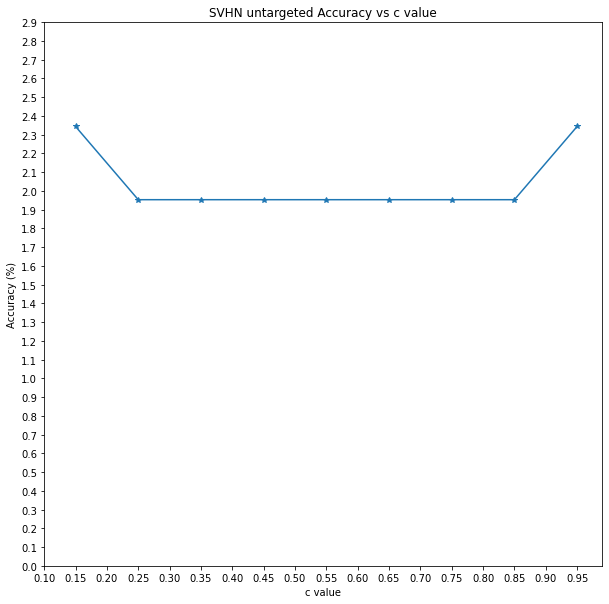

In [81]:
svhn_accuracies = svhn_accuracies[-9:]
print(svhn_accuracies)
plt.figure(figsize=(10,10))
plt.plot(c_vals,svhn_accuracies, "*-")
plt.yticks(np.arange(0, 3, step=0.1))
plt.xticks(np.arange(0.1, 1, step=0.05))
plt.title("SVHN untargeted Accuracy vs c value")
plt.xlabel("c value")
plt.ylabel("Accuracy (%)")
plt.show()

In [62]:
for c_cifar in c_vals:
    acc, _ = test_cw(cifar_resnet_model, test_loader_cifar10, c=c_cifar, mnist = 0)
    cifar10_accuracies.append(acc)    

0 / 1
0 / 2
1 / 3
1 / 4
2 / 5
2 / 6
2 / 7
2 / 8
3 / 9
3 / 10
3 / 11
3 / 12
4 / 13
4 / 14
4 / 15
4 / 16
4 / 17
4 / 18
4 / 19
4 / 20
4 / 21
4 / 22
4 / 23
4 / 24
4 / 25
4 / 26
4 / 27
4 / 28
4 / 29
4 / 30
4 / 31
4 / 32
4 / 33
4 / 34
4 / 35
4 / 36
5 / 37
5 / 38
5 / 39
5 / 40
5 / 41
5 / 42
5 / 43
5 / 44
5 / 45
5 / 46
5 / 47
5 / 48
5 / 49
5 / 50
5 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
6 / 62
6 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
7 / 78
7 / 79
7 / 80
7 / 81
7 / 82
7 / 83
7 / 84
7 / 85
7 / 86
7 / 87
7 / 88
7 / 89
7 / 90
7 / 91
7 / 92
7 / 93
7 / 94
7 / 95
7 / 96
7 / 97
7 / 98
7 / 99
7 / 100
7 / 101
7 / 102
7 / 103
8 / 104
8 / 105
8 / 106
8 / 107
8 / 108
8 / 109
8 / 110
8 / 111
8 / 112
8 / 113
8 / 114
8 / 115
8 / 116
8 / 117
8 / 118
8 / 119
8 / 120
8 / 121
8 / 122
8 / 123
8 / 124
8 / 125
8 / 126
8 / 127
8 / 128
8 / 129
9 / 130
9 / 131
9 / 132
9 / 133
9 / 134
9 / 135
9 / 136
9 / 137
9 / 138
9 / 

17 / 251
17 / 252
17 / 253
17 / 254
17 / 255
17 / 256
Accuracy of test text: 6.640625 %
0 / 1
0 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
2 / 9
2 / 10
2 / 11
2 / 12
3 / 13
3 / 14
3 / 15
3 / 16
3 / 17
3 / 18
3 / 19
3 / 20
3 / 21
3 / 22
4 / 23
4 / 24
4 / 25
4 / 26
4 / 27
4 / 28
4 / 29
4 / 30
4 / 31
4 / 32
4 / 33
4 / 34
4 / 35
4 / 36
5 / 37
5 / 38
5 / 39
5 / 40
5 / 41
5 / 42
5 / 43
5 / 44
5 / 45
5 / 46
5 / 47
5 / 48
5 / 49
5 / 50
5 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
6 / 62
6 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
7 / 78
7 / 79
7 / 80
7 / 81
7 / 82
7 / 83
7 / 84
7 / 85
7 / 86
7 / 87
7 / 88
7 / 89
7 / 90
7 / 91
7 / 92
7 / 93
7 / 94
7 / 95
7 / 96
7 / 97
7 / 98
7 / 99
7 / 100
7 / 101
7 / 102
7 / 103
8 / 104
8 / 105
8 / 106
8 / 107
8 / 108
8 / 109
8 / 110
8 / 111
8 / 112
8 / 113
8 / 114
8 / 115
8 / 116
8 / 117
8 / 118
8 / 119
8 / 120
8 / 121
8 / 122
8 / 123
8 / 124
8 / 125
8 / 126
8 / 127
8 / 

Accuracy of test text: 6.250000 %
0 / 1
0 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
2 / 9
2 / 10
2 / 11
2 / 12
3 / 13
3 / 14
3 / 15
3 / 16
3 / 17
3 / 18
3 / 19
3 / 20
3 / 21
3 / 22
4 / 23
4 / 24
4 / 25
4 / 26
4 / 27
4 / 28
4 / 29
4 / 30
4 / 31
4 / 32
4 / 33
4 / 34
4 / 35
4 / 36
5 / 37
5 / 38
5 / 39
5 / 40
5 / 41
5 / 42
5 / 43
5 / 44
5 / 45
5 / 46
5 / 47
5 / 48
5 / 49
5 / 50
5 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
6 / 62
6 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
7 / 78
7 / 79
7 / 80
7 / 81
7 / 82
7 / 83
7 / 84
7 / 85
7 / 86
7 / 87
7 / 88
7 / 89
7 / 90
7 / 91
7 / 92
7 / 93
7 / 94
7 / 95
7 / 96
7 / 97
7 / 98
7 / 99
7 / 100
7 / 101
7 / 102
7 / 103
8 / 104
8 / 105
8 / 106
8 / 107
8 / 108
8 / 109
8 / 110
8 / 111
8 / 112
8 / 113
8 / 114
8 / 115
8 / 116
8 / 117
8 / 118
8 / 119
8 / 120
8 / 121
8 / 122
8 / 123
8 / 124
8 / 125
8 / 126
8 / 127
8 / 128
8 / 129
8 / 130
8 / 131
8 / 132
8 / 133
8 / 134
8 

[7.03125, 6.640625, 7.03125, 6.640625, 6.640625, 6.25, 6.640625, 6.25, 6.25]


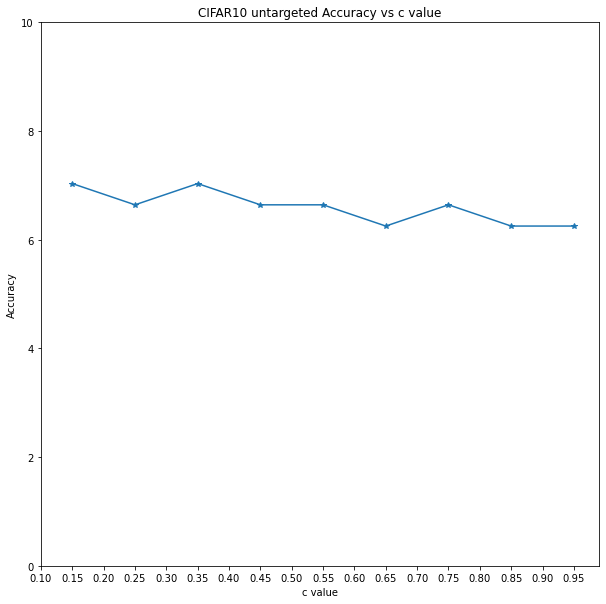

In [67]:
print(cifar10_accuracies)
plt.figure(figsize=(10,10))
plt.plot(c_vals, cifar10_accuracies, "*-")
plt.yticks(np.arange(0, 12, step=2))
plt.xticks(np.arange(0.1, 1, step=0.05))
plt.title("CIFAR10 untargeted Accuracy vs c value")
plt.xlabel("c value")
plt.ylabel("Accuracy")
plt.show()

## MNIST Dataset

### Targeted attack

In [15]:
_, adv_examples = test_cw(mnist_resnet_model, test_loader_mnist, targeted =True, target_label = 8 , mnist = 1)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
0 / 56
0 / 57
0 / 58
0 / 59
0 / 60
0 / 61
1 / 62
1 / 63
1 / 64
1 / 65
1 / 66
1 / 67
1 / 68
1 / 69
1 / 70
1 / 71
1 / 72
1 / 73
1 / 74
1 / 75
1 / 76
1 / 77
1 / 78
1 / 79
1 / 80
1 / 81
1 / 82
1 / 83
1 / 84
2 / 85
2 / 86
2 / 87
2 / 88
2 / 89
2 / 90
2 / 91
2 / 92
2 / 93
2 / 94
2 / 95
2 / 96
2 / 97
2 / 98
2 / 99
2 / 100
2 / 101
2 / 102
2 / 103
Accuracy of test text: 1.941748 %


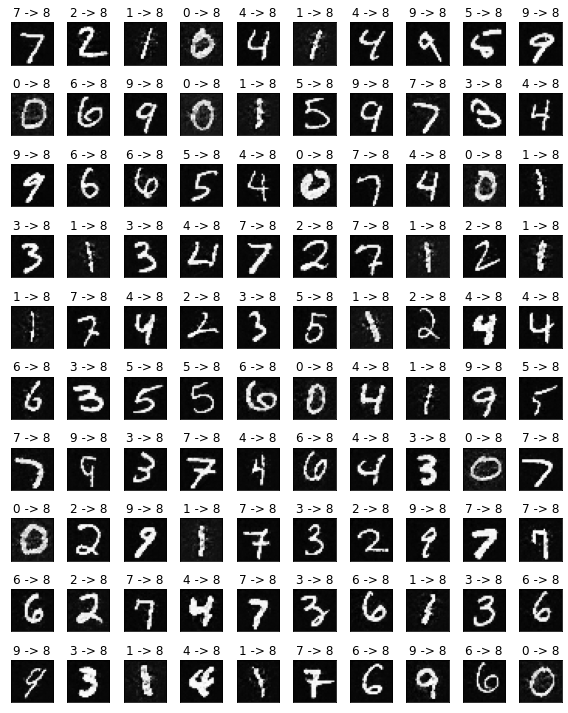

In [16]:
adv_examples = adv_examples[:100]
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### Untargeted attack

In [8]:
_, adv_examples = test_cw(mnist_resnet_model, test_loader_mnist, mnist = 1)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
0 / 56
0 / 57
0 / 58
0 / 59
0 / 60
0 / 61
0 / 62
0 / 63
0 / 64
0 / 65
0 / 66
0 / 67
0 / 68
0 / 69
0 / 70
0 / 71
0 / 72
0 / 73
0 / 74
0 / 75
0 / 76
0 / 77
0 / 78
0 / 79
0 / 80
0 / 81
0 / 82
0 / 83
0 / 84
0 / 85
0 / 86
0 / 87
0 / 88
0 / 89
0 / 90
0 / 91
0 / 92
0 / 93
0 / 94
0 / 95
0 / 96
0 / 97
0 / 98
0 / 99
0 / 100
0 / 101
Accuracy of test text: 0.000000 %


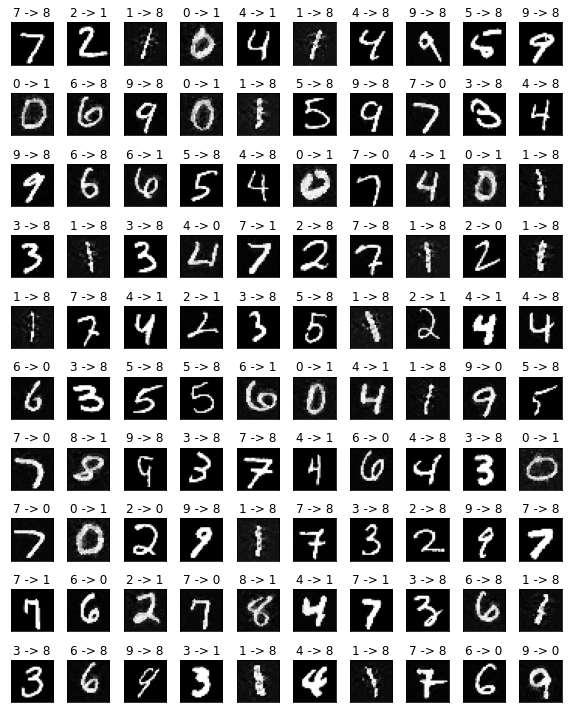

In [9]:
adv_examples = adv_examples[:100]
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## SVHN Dataset

### Targeted attack

In [75]:
_, adv_examples = test_cw(svhn_resnet_model, test_loader_svhn, targeted =True, target_label = 4, mnist = 0)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
1 / 15
2 / 16
2 / 17
2 / 18
2 / 19
3 / 20
3 / 21
3 / 22
3 / 23
3 / 24
3 / 25
3 / 26
4 / 27
4 / 28
5 / 29
5 / 30
5 / 31
5 / 32
5 / 33
5 / 34
5 / 35
5 / 36
5 / 37
5 / 38
5 / 39
5 / 40
5 / 41
5 / 42
5 / 43
5 / 44
5 / 45
5 / 46
5 / 47
5 / 48
5 / 49
5 / 50
5 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
5 / 62
5 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
6 / 69
6 / 70
6 / 71
6 / 72
6 / 73
6 / 74
7 / 75
7 / 76
7 / 77
7 / 78
7 / 79
7 / 80
8 / 81
8 / 82
8 / 83
8 / 84
8 / 85
8 / 86
8 / 87
8 / 88
8 / 89
8 / 90
9 / 91
10 / 92
10 / 93
11 / 94
12 / 95
12 / 96
12 / 97
12 / 98
12 / 99
12 / 100
13 / 101
13 / 102
13 / 103
13 / 104
13 / 105
13 / 106
13 / 107
13 / 108
13 / 109
13 / 110
13 / 111
13 / 112
13 / 113
13 / 114
13 / 115
13 / 116
13 / 117
13 / 118
14 / 119
14 / 120
14 / 121
14 / 122
14 / 123
14 / 124
14 / 125
14 / 126
14 / 127
15 / 128
15 / 129
15 / 130
15 / 131
15 / 132
15 / 133
15

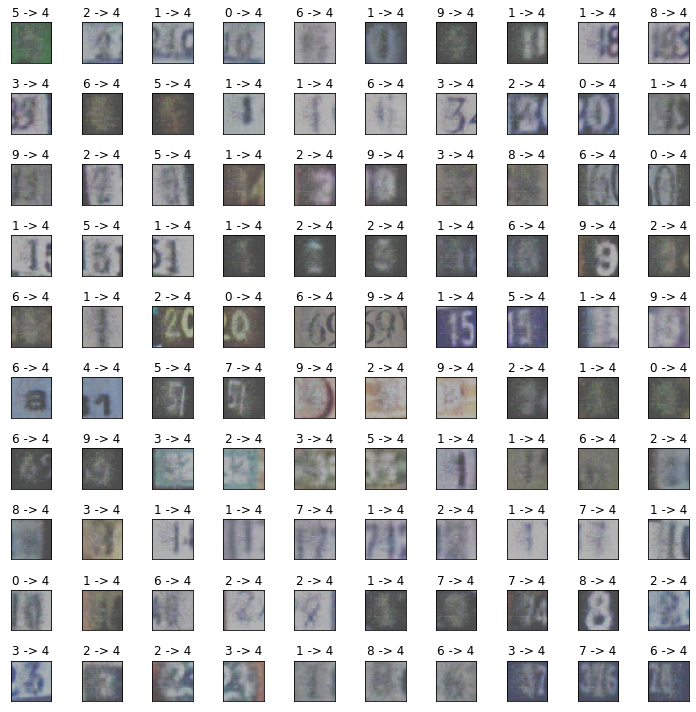

In [76]:
# Test visualizer with an image available in test data
viz = Visualizer()
adv_examples = adv_examples[:100]
plt.figure(figsize=(10, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex # /255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

## Untargeted attack

In [77]:
_, adv_examples = test_cw(svhn_resnet_model, test_loader_svhn, mnist = 0)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
1 / 56
1 / 57
1 / 58
2 / 59
2 / 60
2 / 61
2 / 62
2 / 63
2 / 64
2 / 65
2 / 66
2 / 67
2 / 68
2 / 69
2 / 70
2 / 71
2 / 72
2 / 73
2 / 74
2 / 75
2 / 76
2 / 77
2 / 78
2 / 79
2 / 80
2 / 81
2 / 82
2 / 83
2 / 84
2 / 85
2 / 86
2 / 87
2 / 88
2 / 89
2 / 90
2 / 91
2 / 92
2 / 93
2 / 94
2 / 95
2 / 96
2 / 97
2 / 98
2 / 99
2 / 100
2 / 101
2 / 102
2 / 103
2 / 104
2 / 105
2 / 106
2 / 107
2 / 108
2 / 109
2 / 110
2 / 111
2 / 112
2 / 113
3 / 114
3 / 115
3 / 116
3 / 117
3 / 118
3 / 119
3 / 120
3 / 121
3 / 122
3 / 123
3 / 124
3 / 125
3 / 126
3 / 127
3 / 128
3 / 129
3 / 130
3 / 131
3 / 132
3 / 133
3 / 134
3 / 135
3 / 136
3 / 137
3 / 138
3 / 

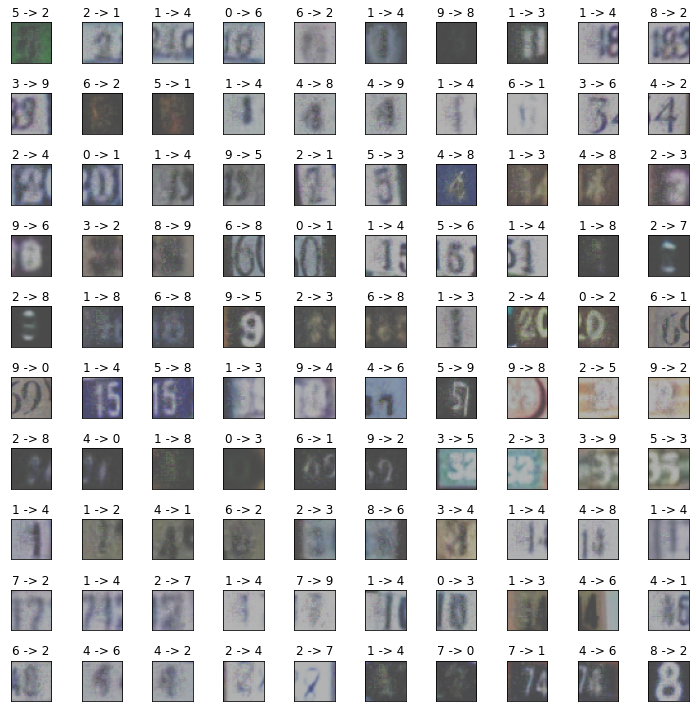

In [78]:
# Test visualizer with an image available in test data
viz = Visualizer()
adv_examples = adv_examples[:100]
plt.figure(figsize=(10, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex # /255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()


## CIFAR10 Dataset

### Targeted attack

In [69]:
_, adv_examples = test_cw(cifar_resnet_model, test_loader_cifar10, targeted =True, target_label = 3, c=0.65, mnist = 0)

1 / 1
1 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
2 / 9
2 / 10
2 / 11
2 / 12
2 / 13
2 / 14
2 / 15
2 / 16
2 / 17
2 / 18
2 / 19
2 / 20
2 / 21
2 / 22
2 / 23
2 / 24
2 / 25
2 / 26
2 / 27
2 / 28
2 / 29
2 / 30
2 / 31
2 / 32
2 / 33
2 / 34
2 / 35
2 / 36
2 / 37
2 / 38
2 / 39
2 / 40
2 / 41
2 / 42
2 / 43
2 / 44
2 / 45
2 / 46
3 / 47
3 / 48
3 / 49
3 / 50
3 / 51
3 / 52
3 / 53
4 / 54
4 / 55
4 / 56
4 / 57
4 / 58
4 / 59
4 / 60
4 / 61
5 / 62
5 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
8 / 78
9 / 79
9 / 80
9 / 81
9 / 82
9 / 83
9 / 84
9 / 85
9 / 86
9 / 87
9 / 88
9 / 89
9 / 90
9 / 91
10 / 92
10 / 93
10 / 94
10 / 95
10 / 96
10 / 97
10 / 98
10 / 99
10 / 100
10 / 101
10 / 102
10 / 103
11 / 104
11 / 105
11 / 106
12 / 107
12 / 108
12 / 109
12 / 110
12 / 111
12 / 112
12 / 113
12 / 114
12 / 115
13 / 116
13 / 117
13 / 118
13 / 119
13 / 120
13 / 121
14 / 122
14 / 123
14 / 124
14 / 125
14 / 126
14 / 127
15 / 128
15 / 129
15 / 130
15 / 131
15 / 132
15 / 133
15

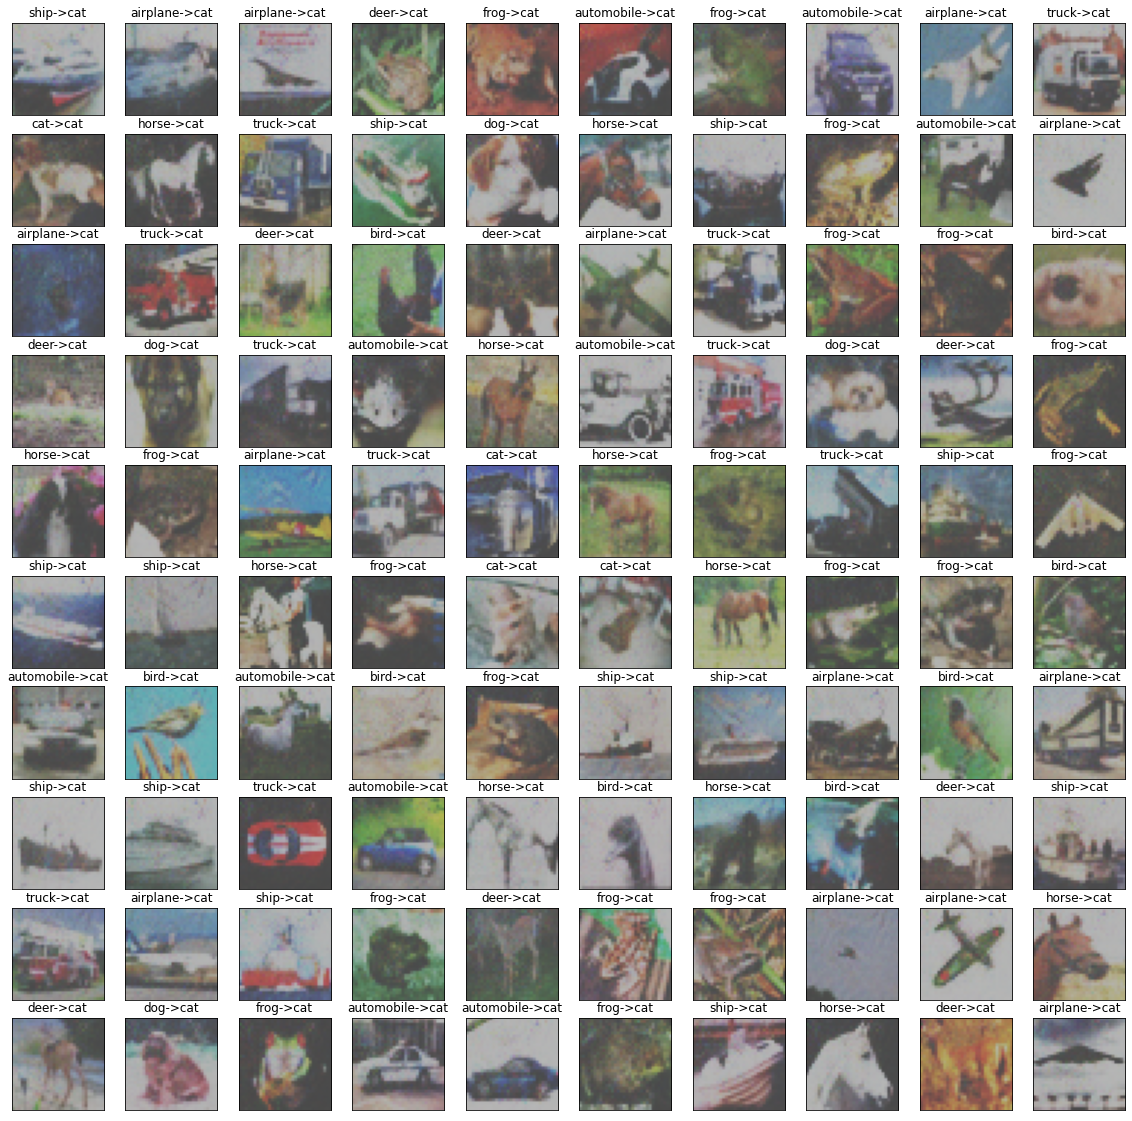

In [70]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
adv_examples = adv_examples[:100]
plt.figure(figsize=(20, 20))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{label_mapping[orig.item()]}->{label_mapping[adv.item()]}")
    plt.imshow(ex)

plt.show()


### Untargeted attack

In [71]:
_, adv_examples = test_cw(cifar_resnet_model, test_loader_cifar10, c=0.65, mnist = 0)

0 / 1
0 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
2 / 9
2 / 10
2 / 11
2 / 12
3 / 13
3 / 14
3 / 15
3 / 16
3 / 17
3 / 18
3 / 19
3 / 20
3 / 21
3 / 22
4 / 23
4 / 24
4 / 25
4 / 26
4 / 27
4 / 28
4 / 29
4 / 30
4 / 31
4 / 32
4 / 33
4 / 34
4 / 35
4 / 36
5 / 37
5 / 38
5 / 39
5 / 40
5 / 41
5 / 42
5 / 43
5 / 44
5 / 45
5 / 46
5 / 47
5 / 48
5 / 49
5 / 50
5 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
6 / 62
6 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
7 / 78
7 / 79
7 / 80
7 / 81
7 / 82
7 / 83
7 / 84
7 / 85
7 / 86
7 / 87
7 / 88
7 / 89
7 / 90
7 / 91
7 / 92
7 / 93
7 / 94
7 / 95
7 / 96
7 / 97
7 / 98
7 / 99
7 / 100
7 / 101
7 / 102
7 / 103
8 / 104
8 / 105
8 / 106
8 / 107
8 / 108
8 / 109
8 / 110
8 / 111
8 / 112
8 / 113
8 / 114
8 / 115
8 / 116
8 / 117
8 / 118
8 / 119
8 / 120
8 / 121
8 / 122
8 / 123
8 / 124
8 / 125
8 / 126
8 / 127
8 / 128
8 / 129
8 / 130
8 / 131
8 / 132
8 / 133
8 / 134
8 / 135
8 / 136
8 / 137
8 / 138
8 / 

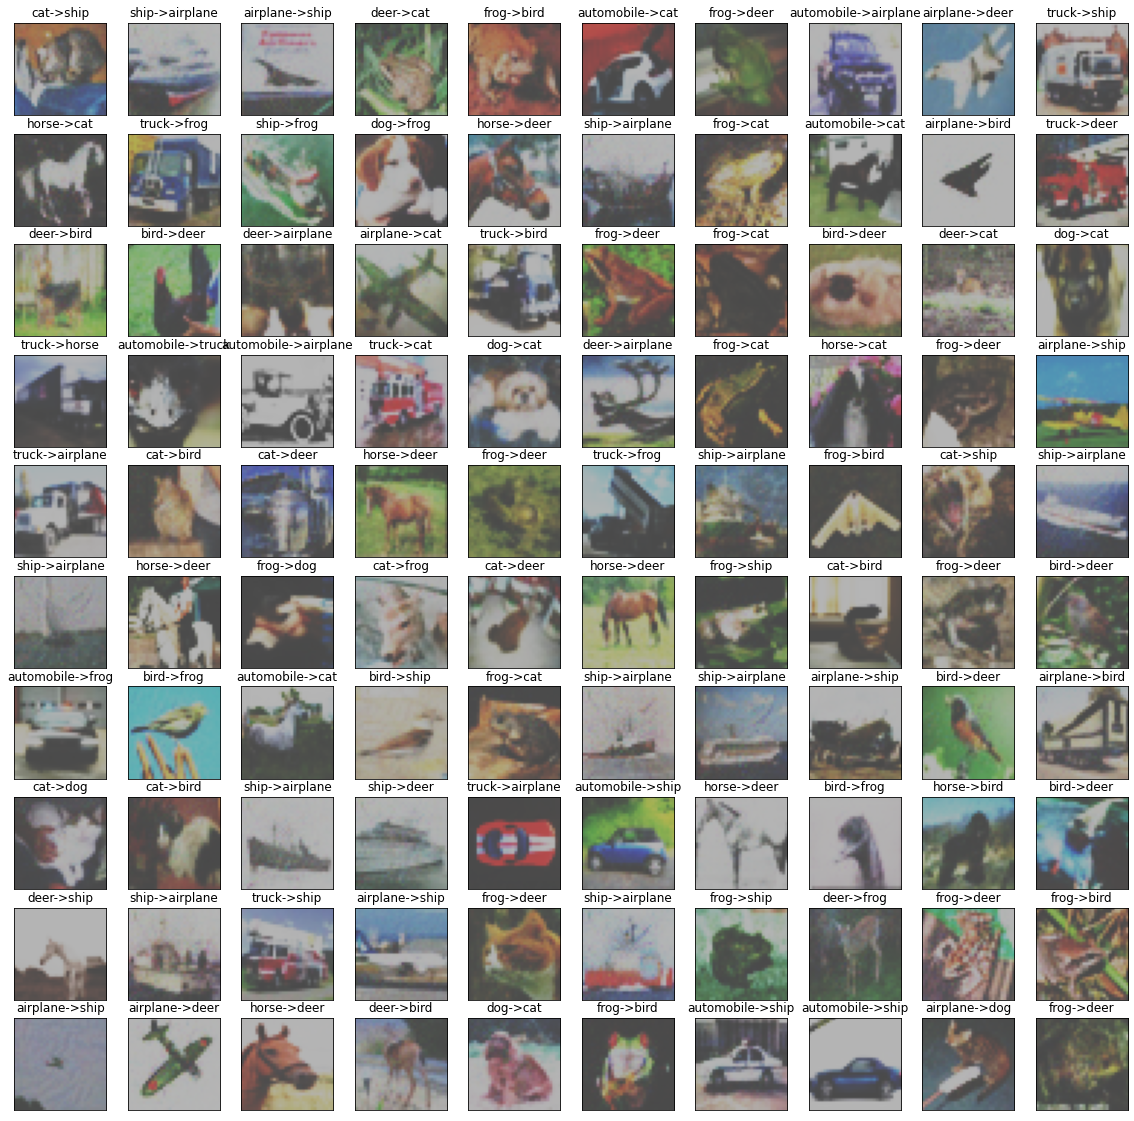

In [72]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
adv_examples = adv_examples[:100]
plt.figure(figsize=(20, 20))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{label_mapping[orig.item()]}->{label_mapping[adv.item()]}")
    plt.imshow(ex)

plt.show()